In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import layers
import shap

In [2]:
# Simple Function to calcuate CVD
def calculate_CVD(a,b,c,d,e):
    col=0
    if (int(a)==1 or int(b)==1 or int(c)==1 or int(d)==1 or int(e)==1):
        col=1
    elif (int(a)==0 and int(b)==0 and int(c)==0 and int(d)==0 and int(e)==0):
        col = 0
    elif (int(a)==pd.isna and int(b)==pd.isna and int(c)==pd.isna and int(d)==pd.isna and int(e)==pd.isna):
        col = 0
    return col

In [3]:
data = pd.read_csv('cardio_train1.csv')
# print(data.head())


# # EDA and preproccesing 
# print(data.isna().sum())
X = data.iloc[:, 1:-1]
Y = data.iloc[:, -1]


In [4]:
XX = ['age', 'gender', 'weight', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
YY = ['cardio']

# Split the data into features and target variables
features = data[XX]
targets = data[YY]

In [5]:
# Split the data into train and test sets (stratified by sex and one outcome variable)
train_features, test_features, train_targets, test_targets = train_test_split(
    features, targets, test_size=0.2, stratify=features[['gender']], random_state=42)

In [6]:
train_targets_scaled.dtypes

NameError: name 'train_targets_scaled' is not defined

In [7]:
# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)
# train_targets_scaled = scaler.transform(train_targets)
# class_weight.compute_class_weight('balanced',n_samples / (n_classes * np.bincount(y)))
# Calculate class weights for handling class imbalance
# class_weights = class_weight.compute_class_weight(class_weight= "balanced", classes= np.unique(train_targets_scaled), y= train_targets_scaled)
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_targets), train_targets)

In [9]:
# Train and evaluate the models
models = []
class_weights = {0: 1, 1: 2.2}
# XGBoost
xgb_model = xgb.XGBClassifier()
xgb_model.fit(train_features_scaled, train_targets['cardio'])
xgb_preds = xgb_model.predict(test_features_scaled)
print("XGBoost:")
print(classification_report(test_targets['cardio'], xgb_preds))
models.append(xgb_model)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(train_features_scaled, train_targets['cardio'])
rf_preds = rf_model.predict(test_features_scaled)
print("Random Forest:")
print(classification_report(test_targets['cardio'], rf_preds))
models.append(rf_model)

XGBoost:
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      7001
           1       0.76      0.70      0.73      6999

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000

Random Forest:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      7001
           1       0.68      0.70      0.69      6999

    accuracy                           0.69     14000
   macro avg       0.69      0.69      0.69     14000
weighted avg       0.69      0.69      0.69     14000



Epoch 1/15
4308/4308 [==============================] - 2s 448us/step - loss: 0.6336 - accuracy: 0.6363 - val_loss: 0.5664 - val_accuracy: 0.7214
Epoch 2/15
4308/4308 [==============================] - 2s 376us/step - loss: 0.5679 - accuracy: 0.7224 - val_loss: 0.5518 - val_accuracy: 0.7338
Epoch 3/15
4308/4308 [==============================] - 2s 377us/step - loss: 0.5518 - accuracy: 0.7291 - val_loss: 0.5483 - val_accuracy: 0.7331
Epoch 4/15
4308/4308 [==============================] - 2s 398us/step - loss: 0.5516 - accuracy: 0.7284 - val_loss: 0.5457 - val_accuracy: 0.7333
Epoch 5/15
4308/4308 [==============================] - 2s 399us/step - loss: 0.5488 - accuracy: 0.7293 - val_loss: 0.5456 - val_accuracy: 0.7340
Epoch 6/15
4308/4308 [==============================] - 2s 384us/step - loss: 0.5511 - accuracy: 0.7287 - val_loss: 0.5444 - val_accuracy: 0.7346
Epoch 7/15
4308/4308 [==============================] - 2s 380us/step - loss: 0.5447 - accuracy: 0.7306 - val_loss: 0.5418 -

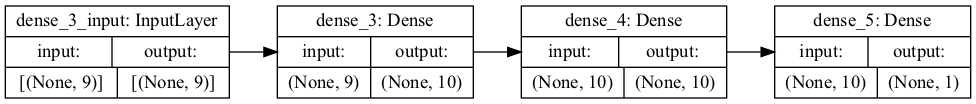

In [26]:
scaler = StandardScaler().fit(train_features[XX]) 

train_features[XX] = scaler.transform(train_features[XX])
test_features[XX] = scaler.transform(test_features[XX])

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

model.fit(train_features[XX], train_targets['cardio'], 
         epochs=15, 
         batch_size=13,
         validation_data=(test_features[XX], test_targets['cardio'])
         )

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### SHAP Analysis

In [10]:
# SHAP Analysis
shap.initjs()
explainer = shap.Explainer(xgb_model, train_features_scaled)
shap_values = explainer(test_features_scaled)

 99%|===================| 13906/14000 [00:21<00:00]        

In [106]:
shap.initjs()
explainer1 = shap.KernelExplainer(model, test_features.iloc[1:500])
# shap_values = explainer(X_test)
shap_values1 = explainer1.shap_values(test_features.iloc[50,:], nsamples=1000)

Using 499 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [76]:
explainer2 = shap.KernelExplainer(model, test_features)
# shap_values = explainer(X_test)
shap_values2 = explainer2.shap_values(test_features.iloc[500], nsamples=1000)

Using 14000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


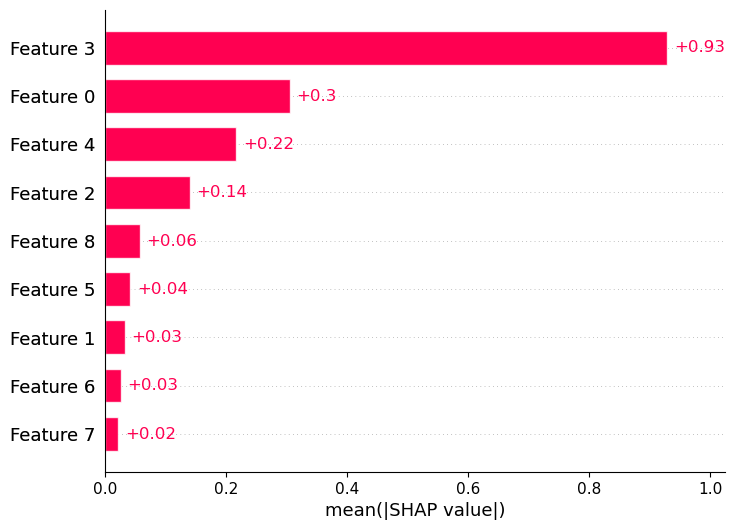

In [13]:
shap.initjs()
# shap.force_plot(explainer.explain_row, shap_values[0], train_features_scaled[0,:])
shap.plots.bar(shap_values, max_display=10)

In [92]:
# shap.force_plot(explainer1.expected_value, shap_values.values[20,:], test_features.iloc[20,:])
shap.force_plot(explainer1.expected_value, shap_values1[0], test_features.iloc[20,:])

In [98]:
rf_shap_values = shap.KernelExplainer(model.predict,test_features)

Using 14000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [116]:
shap50 = rf_shap_values.shap_values(test_features.iloc[50:100,:])
shap.force_plot(rf_shap_values.expected_value, shap50[0], test_features.iloc[50:100,:])

  0%|          | 0/50 [00:00<?, ?it/s]

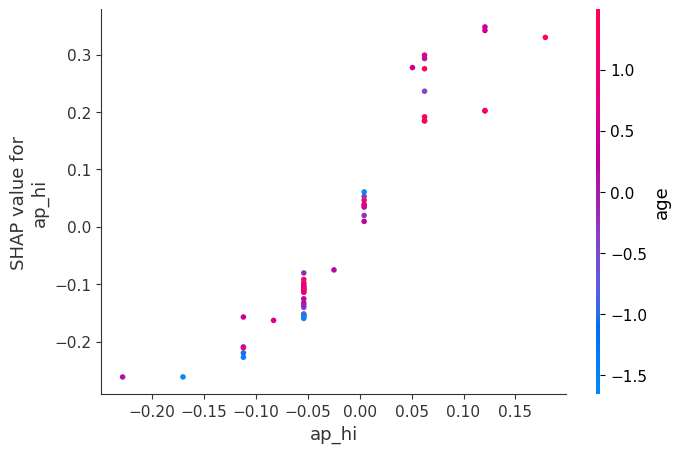

In [122]:
shap.dependence_plot("ap_hi", shap50[0], test_features.iloc[50:100,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


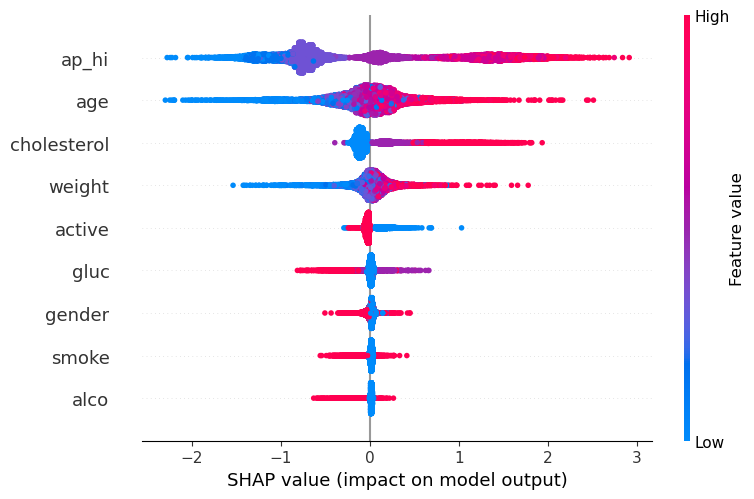

In [17]:
shap.summary_plot(shap_values, test_features_scaled, feature_names = XX)

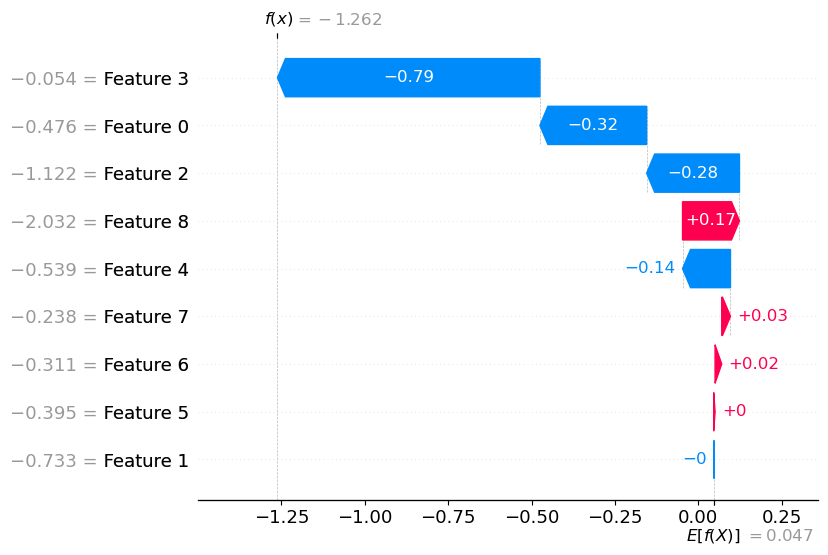

In [21]:
shap.plots.waterfall(shap_values[0])

In [24]:
shap.plots.heatmap(shap_values)

In [ ]:
# f = lambda x: knn_norm.predict_proba(x)[:,1]
# med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))

# explainer = shap.Explainer(f, med)

# shap_values_norm = explainer(X_valid_norm.iloc[0:1000,:])

In [107]:
shap_values1

[array([-0.01583896, -0.01011796,  0.01563799,  0.01342295, -0.05292766,
        -0.00355038, -0.06048013,  0.00361796, -0.00425287])]